In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import gc 
import warnings 
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

In [2]:
application_train = pd.read_csv('../input/home-credit-default-risk/application_train.csv')
application_test = pd.read_csv('../input/home-credit-default-risk/application_test.csv')
bureau = pd.read_csv('../input/home-credit-default-risk/bureau.csv')
bureau_balance = pd.read_csv('../input/home-credit-default-risk/bureau_balance.csv')

In [3]:
def agg_numeric(df, group_var, df_name):
    numeric_df = df.select_dtypes('number')
    numeric_df = numeric_df.groupby(group_var).agg(['mean', 'sum','max','min','count']).reset_index()
    
    columns = [group_var]
    for var in numeric_df.columns.levels[0]:
        if var != group_var:
            for stat in numeric_df.columns.levels[1][:-1]:
                columns.append('%s_%s_%s'%(df_name, var, stat))
    numeric_df.columns = columns
    return numeric_df

def count_categorical(df, group_var, df_name):
    categorical_df = pd.get_dummies(df.select_dtypes('object'))
    categorical_df[group_var] = df[group_var]
    
    categorical_df = categorical_df.groupby(group_var).agg(['sum','mean'])
    
    columns = []
    
    for var in categorical_df.columns.levels[0]:
        for stat in ['count','mean']:
            columns.append('%s_%s_%s'%(df_name, var, stat))
    categorical_df.columns = columns
    return categorical_df

In [4]:
bureau_agg = agg_numeric(bureau.drop(columns ='SK_ID_BUREAU'), 'SK_ID_CURR', 'bureau')
bureau_count = count_categorical(bureau.drop(columns ='SK_ID_BUREAU'), 'SK_ID_CURR', 'bureau')
bureau_balance_agg = agg_numeric(bureau_balance, 'SK_ID_BUREAU', 'bureau_balance')
bureau_balance_count = count_categorical(bureau_balance, 'SK_ID_BUREAU', 'bureau_balance')

In [5]:
bureau_balance_by_bureau = bureau_balance_agg.merge(bureau_balance_count, left_on ='SK_ID_BUREAU', right_index= True, how = 'outer')
bureau_balance_by_client = bureau[['SK_ID_CURR', 'SK_ID_BUREAU']].merge(bureau_balance_by_bureau, on = 'SK_ID_BUREAU', how = 'left')
bureau_balance_by_client = agg_numeric(bureau_balance_by_client.drop(columns='SK_ID_BUREAU'),'SK_ID_CURR', 'client')

In [6]:
train = application_train.merge(bureau_count, on ='SK_ID_CURR', how='left')
train = train.merge(bureau_agg, on ='SK_ID_CURR', how='left')
train = train.merge(bureau_balance_by_client, on ='SK_ID_CURR', how='left')

In [7]:
test = application_test.merge(bureau_count, on ='SK_ID_CURR', how='left')
test = test.merge(bureau_agg, on ='SK_ID_CURR', how='left')
test = test.merge(bureau_balance_by_client, on ='SK_ID_CURR', how='left')

In [8]:
print('Training Data Shape:', train.shape)
print('Testing Data Shape:', test.shape)

Training Data Shape: (307511, 333)
Testing Data Shape: (48744, 332)


In [9]:
train_labels = train['TARGET']
train, test= train.align(test, join='inner', axis = 1)
train['TARGET'] = train_labels 

In [10]:
print('Training Data Shape:', train.shape)
print('Testing Data Shape:', test.shape)

Training Data Shape: (307511, 333)
Testing Data Shape: (48744, 332)


In [11]:
train.to_csv('train_bureau.csv', index = False)
test.to_csv('test_bureau.csv', index = False)

## Feature Engineering

In [12]:
train.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,client_bureau_balance_STATUS_X_count_sum,client_bureau_balance_STATUS_X_count_max,client_bureau_balance_STATUS_X_count_min,client_bureau_balance_STATUS_X_count_count,client_bureau_balance_STATUS_X_mean_mean,client_bureau_balance_STATUS_X_mean_sum,client_bureau_balance_STATUS_X_mean_max,client_bureau_balance_STATUS_X_mean_min,client_bureau_balance_STATUS_X_mean_count,TARGET
0,100002,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,15.0,3.0,0.0,8.0,0.161932,1.295455,0.5,0.0,8.0,1
1,100003,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0.0,NaN,NaN,0.0,NaN,0.000000,NaN,NaN,0.0,0
2,100004,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0.0,NaN,NaN,0.0,NaN,0.000000,NaN,NaN,0.0,0
3,100006,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,100007,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0.0,NaN,NaN,0.0,NaN,0.000000,NaN,NaN,0.0,0


In [13]:
def get_age_label(days_birth):
    """ Return the age group label (int). """
    age_years = -days_birth / 365
    if age_years < 27: return 1
    elif age_years < 40: return 2
    elif age_years < 50: return 3
    elif age_years < 65: return 4
    elif age_years < 99: return 5
    else: return 0

In [14]:
# ------------------------- UTILITY FUNCTIONS -------------------------

def do_mean(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].mean().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df


def do_median(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].median().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df


def do_std(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].std().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df


def do_sum(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].sum().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df

In [15]:
def feature_engineering(df):
    df = df[df['CODE_GENDER'] != 'XNA']
    df = df[df['AMT_INCOME_TOTAL'] < 20000000]
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
    df['DAYS_LAST_PHONE_CHANGE'].replace(0, np.nan, inplace=True)
    
    docs = [f for f in df.columns if 'FLAG_DOC' in f]
    df['DOCUMENT_COUNT'] = df[docs].sum(axis=1)
    df['NEW_DOC_KURT'] = df[docs].sum(axis=1)
    
    df['AGE_RANGE'] = df['DAYS_BIRTH'].apply(lambda x: get_age_label(x))
    
    df['EXT_SOURCES_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    df['EXT_SOURCE_WEIGHT'] = df['EXT_SOURCE_1']*2 + df['EXT_SOURCE_2'] *1 + df['EXT_SOURCE_3'] *3
    
    for function_name in ['min', 'max', 'mean', 'nanmedian', 'var']:
        feature_name = 'EXT_SOURCES_{}'.format(function_name.upper())
        df[feature_name] = eval('np.{}'.format(function_name))(
            df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']], axis=1)

    # Credit ratios
    df['CREDIT_TO_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
    df['CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
    # Income ratios
    df['ANNUITY_TO_INCOME_RATIO'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['CREDIT_TO_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
    df['INCOME_TO_EMPLOYED_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_EMPLOYED']
    df['INCOME_TO_BIRTH_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_BIRTH']
    # Time ratios
    df['EMPLOYED_TO_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['ID_TO_BIRTH_RATIO'] = df['DAYS_ID_PUBLISH'] / df['DAYS_BIRTH']
    df['CAR_TO_BIRTH_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
    df['CAR_TO_EMPLOYED_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']
    df['PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']
    
    # Groupby: Statistics for applications in the same group
    group = ['ORGANIZATION_TYPE', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 'AGE_RANGE', 'CODE_GENDER']
    df = do_median(df, group, 'EXT_SOURCES_MEAN', 'GROUP_EXT_SOURCES_MEDIAN')
    df = do_std(df, group, 'EXT_SOURCES_MEAN', 'GROUP_EXT_SOURCES_STD')
    df = do_mean(df, group, 'AMT_INCOME_TOTAL', 'GROUP_INCOME_MEAN')
    df = do_std(df, group, 'AMT_INCOME_TOTAL', 'GROUP_INCOME_STD')
    df = do_mean(df, group, 'CREDIT_TO_ANNUITY_RATIO', 'GROUP_CREDIT_TO_ANNUITY_MEAN')
    df = do_std(df, group, 'CREDIT_TO_ANNUITY_RATIO', 'GROUP_CREDIT_TO_ANNUITY_STD')
    df = do_mean(df, group, 'AMT_CREDIT', 'GROUP_CREDIT_MEAN')
    df = do_mean(df, group, 'AMT_ANNUITY', 'GROUP_ANNUITY_MEAN')
    df = do_std(df, group, 'AMT_ANNUITY', 'GROUP_ANNUITY_STD')

    df = df.reset_index(drop=True)
    return df

In [16]:
train_feature_engineered = feature_engineering(train)
test_feature_engineered = feature_engineering(test)
print('Training data shape: ', train_feature_engineered.shape)
print('Testing data shape: ', test_feature_engineered.shape)

Training data shape:  (307506, 363)
Testing data shape:  (48744, 362)


In [17]:
train_feature_engineered.to_csv('train_feature_engineered.csv', index = False)
test_feature_engineered.to_csv('test_feature_engineered.csv', index = False)

### Permutation Importances

In [18]:
#Do not support special JSON characters in feature name -> light gbm에서 column 명에 " , : [ ] { } 문자가 포함되어 있을 경우 false를 리턴한다.
from sklearn.model_selection import train_test_split

import lightgbm as lgb
from sklearn import metrics
import re

from sklearn.preprocessing import LabelEncoder

labels = train_feature_engineered['TARGET']
X = train_feature_engineered.drop(columns='TARGET')

label_encoder = LabelEncoder()
cat_indices = []

for i, col in enumerate(X):
    if X[col].dtype == 'object':
        X[col] = label_encoder.fit_transform(np.array(X[col].astype(str)).reshape(-1,))
        cat_indices.append(i)
#X = X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
Y = labels

x_train, x_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.2, shuffle=True, stratify=Y, random_state=34)

In [19]:
#0.768
model = lgb.LGBMClassifier(n_estimators = 10000
                               , objective='binary'
                               , class_weight = 'balanced'
                               , learning_rate = 0.05
                               , reg_alpha = 0.1
                               , reg_lambda = 0.1
                               , subsample = 0.8
                               , n_jobs = -1
                               , random_state= 50)
model.fit(x_train, y_train, eval_metric = 'auc', eval_set = [(x_valid, y_valid), (x_train, y_train)]
                 , eval_names =['valid','train'], early_stopping_rounds = 100
                 , verbose = 200, categorical_feature = cat_indices)

print('train accuracy: ', model.best_score_['train']['auc'])
print('test accuracy: ', model.best_score_['valid']['auc'])

[200]	train's auc: 0.823718	train's binary_logloss: 0.522294	valid's auc: 0.769517	valid's binary_logloss: 0.544467
train accuracy:  0.8379553122953806
test accuracy:  0.7701926931041656


In [20]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model, random_state = 1).fit(x_valid, y_valid)
eli5.show_weights(perm, feature_names = x_valid.columns.tolist())

Weight,Feature
0.0052 ± 0.0008,DAYS_BIRTH
0.0047 ± 0.0010,EXT_SOURCE_1
0.0025 ± 0.0007,AMT_ANNUITY
0.0021 ± 0.0013,CODE_GENDER
0.0015 ± 0.0007,NAME_FAMILY_STATUS
0.0015 ± 0.0008,AMT_GOODS_PRICE
0.0013 ± 0.0004,bureau_AMT_CREDIT_SUM_min
0.0013 ± 0.0004,bureau_CREDIT_ACTIVE_Closed_mean
0.0009 ± 0.0002,AGE_RANGE
0.0007 ± 0.0003,bureau_AMT_CREDIT_SUM_LIMIT_count


In [21]:
pfi = pd.DataFrame({'column':X.columns,'importace': perm.feature_importances_, 'abs_importance': np.abs(perm.feature_importances_)})
pfi.sort_values('abs_importance',ascending=False).tail(10)

,column,importace,abs_importance
135,bureau_CREDIT_CURRENCY_currency 4_count,0.0,0.0
136,bureau_CREDIT_CURRENCY_currency 4_mean,0.0,0.0
137,bureau_CREDIT_TYPE_Another type of loan_count,0.0,0.0
266,client_bureau_balance_STATUS_1_count_count,0.0,0.0
263,client_bureau_balance_STATUS_1_count_sum,0.0,0.0
138,bureau_CREDIT_TYPE_Another type of loan_mean,0.0,0.0
261,client_bureau_balance_STATUS_0_mean_count,0.0,0.0
141,bureau_CREDIT_TYPE_Cash loan (non-earmarked)_c...,0.0,0.0
142,bureau_CREDIT_TYPE_Cash loan (non-earmarked)_mean,0.0,0.0
284,client_bureau_balance_STATUS_3_count_max,0.0,0.0


In [22]:
removed_columns = list(pfi.sort_values('abs_importance',ascending=False).tail(20)['column'])
print(removed_columns)

['client_bureau_balance_STATUS_2_mean_min', 'bureau_CREDIT_CURRENCY_currency 2_mean', 'bureau_CREDIT_CURRENCY_currency 3_count', 'client_bureau_balance_STATUS_2_count_min', 'bureau_CREDIT_TYPE_Interbank credit_count', 'client_bureau_balance_STATUS_2_count_max', 'client_bureau_balance_STATUS_2_count_sum', 'LIVE_CITY_NOT_WORK_CITY', 'client_bureau_balance_STATUS_1_mean_count', 'bureau_CREDIT_CURRENCY_currency 3_mean', 'bureau_CREDIT_CURRENCY_currency 4_count', 'bureau_CREDIT_CURRENCY_currency 4_mean', 'bureau_CREDIT_TYPE_Another type of loan_count', 'client_bureau_balance_STATUS_1_count_count', 'client_bureau_balance_STATUS_1_count_sum', 'bureau_CREDIT_TYPE_Another type of loan_mean', 'client_bureau_balance_STATUS_0_mean_count', 'bureau_CREDIT_TYPE_Cash loan (non-earmarked)_count', 'bureau_CREDIT_TYPE_Cash loan (non-earmarked)_mean', 'client_bureau_balance_STATUS_3_count_max']


In [23]:
removed_train_feature_engineered = train_feature_engineered.drop(columns=removed_columns)
removed_test_feature_engineered = test_feature_engineered.drop(columns=removed_columns)

In [24]:
removed_train_feature_engineered.to_csv('removed_train_feature_engineered.csv', index = False)
removed_test_feature_engineered.to_csv('removed_test_feature_engineered.csv', index = False)

In [25]:
import lightgbm as lgb

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

import gc
import matplotlib.pyplot as plt

In [26]:
def model(features, test_features, encoding = 'ohe', n_folds =5):
    labels = features['TARGET']
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    train = features.drop(columns = ['TARGET','SK_ID_CURR'])
    test = test_features.drop(columns = 'SK_ID_CURR')
    
    if encoding == 'ohe':
        train = pd.get_dummies(train)
        test = pd.get_dummies(test)
        
        train, test = train.align(test, join='inner', axis =1)
        cat_indices = 'auto'
    elif encoding == 'le':
        label_encoder = LabelEncoder()
        cat_indices = []
        
        for i, col in enumerate(train):
            if train[col] == 'object':
                train[col] = label_encoder.fit_transform(np.array(train[col].astype(str)).reshape(-1,))
                test[col] = label_encoder.transform(np.array(test[col].astype(str)).reshape(-1,))
                cat_indices.append(i)
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
    print('Traing Data Shape:', train.shape)
    print('Testing Data Shape:', test.shape)
    
    feature_names = list(train.columns)
    
    train = np.array(train)
    test = np.array(test)
    
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    feature_importance_values = np.zeros(len(feature_names))
    
    test_predictions = np.zeros(len(test))
    out_of_fold = np.zeros(len(train))
    
    valid_scores = []
    train_scores = []
    
    for train_indices, valid_indices in k_fold.split(train):
        train_features, train_labels = train[train_indices], labels[train_indices]
        valid_features, valid_labels = train[valid_indices], labels[valid_indices]
        
        model = lgb.LGBMClassifier(n_estimators = 10000
                                   , objective='binary'
                                   , class_weight = 'balanced'
                                   , learning_rate = 0.05
                                   , reg_alpha = 0.1
                                   , reg_lambda = 0.1
                                   , subsample = 0.8
                                   , n_jobs = -1
                                   , random_state= 50
                                  )
        model.fit(train_features
                 , train_labels
                 , eval_metric = 'auc'
                 , eval_set = [(valid_features, valid_labels), (train_features, train_labels)]
                 , eval_names =['valid','train']
                 , categorical_feature = cat_indices
                 , early_stopping_rounds = 100
                 , verbose = 200
        )
        best_iteration = model.best_iteration_
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        test_predictions += model.predict_proba(test, num_iteration = best_iteration)[:,1] / k_fold.n_splits
        
        out_of_fold[valid_indices] =model.predict_proba(valid_features, num_iteration = best_iteration)[:,1]
        
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    feature_importacne = pd.DataFrame({'feature':feature_names, 'importance':feature_importance_values})
    
    submission = pd.DataFrame({'SK_ID_CURR':test_ids, 'TARGET':test_predictions})
    
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    metrics = pd.DataFrame({'fold':fold_names, 'train':train_scores, 'valid': valid_scores})
    return submission, feature_importacne, metrics

In [27]:
def plot_feature_importances(df):
    df = df.sort_values('importance', ascending = False).reset_index()
    
    df['importance_nomalized'] = df['importance'] / df['importance'].sum()
    
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    ax.barh(list(reversed(list(df.index[:15]))),
           df['importance_nomalized'].head(15),
           align = 'center',
           edgecolor = 'k')
    
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    plt.xlabel('Normalized Importance')
    plt.ylabel('Feature Importances')
    plt.show()
    
    return df

In [28]:
submission, fi, metrics = model(train,test)

Traing Data Shape: (307511, 452)
Testing Data Shape: (48744, 452)
[200]	train's auc: 0.810821	train's binary_logloss: 0.53617	valid's auc: 0.763278	valid's binary_logloss: 0.553135
[200]	train's auc: 0.810727	train's binary_logloss: 0.53666	valid's auc: 0.765248	valid's binary_logloss: 0.553447
[200]	train's auc: 0.809569	train's binary_logloss: 0.538079	valid's auc: 0.770518	valid's binary_logloss: 0.554759
[200]	train's auc: 0.810367	train's binary_logloss: 0.537096	valid's auc: 0.765831	valid's binary_logloss: 0.552573
[200]	train's auc: 0.810433	train's binary_logloss: 0.536726	valid's auc: 0.76417	valid's binary_logloss: 0.554751


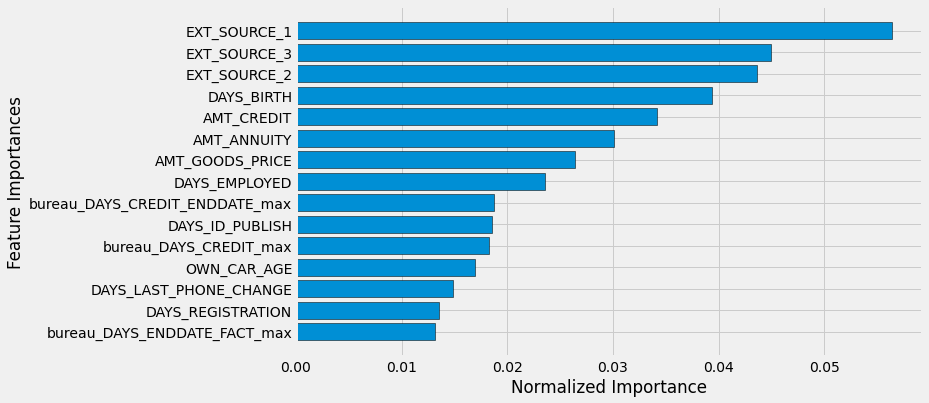

,index,feature,importance,importance_nomalized
0,27,EXT_SOURCE_1,452.8,0.056445
1,29,EXT_SOURCE_3,360.4,0.044926
2,28,EXT_SOURCE_2,350.0,0.043630
3,6,DAYS_BIRTH,315.8,0.039367
4,2,AMT_CREDIT,274.4,0.034206
...,...,...,...,...
447,135,bureau_CREDIT_TYPE_Loan for purchase of shares...,0.0,0.000000
448,325,NAME_TYPE_SUITE_Group of people,0.0,0.000000
449,322,FLAG_OWN_REALTY_Y,0.0,0.000000
450,134,bureau_CREDIT_TYPE_Loan for purchase of shares...,0.0,0.000000


In [29]:
plot_feature_importances(fi)

In [30]:
metrics

,fold,train,valid
0,0,0.823660,0.763730
1,1,0.824682,0.766092
2,2,0.826798,0.771362
3,3,0.817720,0.766207
4,4,0.821525,0.764642
5,overall,0.822877,0.766404


In [31]:
submission_engineered, fi_engineered, metrics_engineered = model(train_feature_engineered, test_feature_engineered)

Traing Data Shape: (307506, 482)
Testing Data Shape: (48744, 482)
[200]	train's auc: 0.816906	train's binary_logloss: 0.528855	valid's auc: 0.770793	valid's binary_logloss: 0.545976
[200]	train's auc: 0.815646	train's binary_logloss: 0.530263	valid's auc: 0.775005	valid's binary_logloss: 0.546945
[400]	train's auc: 0.851118	train's binary_logloss: 0.492799	valid's auc: 0.776481	valid's binary_logloss: 0.52303
[200]	train's auc: 0.817126	train's binary_logloss: 0.528981	valid's auc: 0.771315	valid's binary_logloss: 0.549057
[200]	train's auc: 0.815824	train's binary_logloss: 0.530126	valid's auc: 0.775153	valid's binary_logloss: 0.547871
[200]	train's auc: 0.81707	train's binary_logloss: 0.528558	valid's auc: 0.767887	valid's binary_logloss: 0.548611
[400]	train's auc: 0.852711	train's binary_logloss: 0.490847	valid's auc: 0.768842	valid's binary_logloss: 0.525221


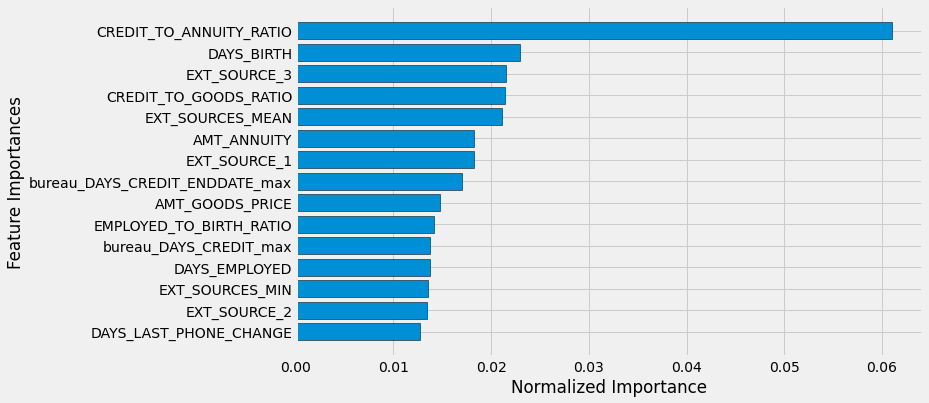

,index,feature,importance,importance_nomalized
0,325,CREDIT_TO_ANNUITY_RATIO,524.8,0.061080
1,6,DAYS_BIRTH,197.6,0.022998
2,29,EXT_SOURCE_3,185.0,0.021532
3,326,CREDIT_TO_GOODS_RATIO,183.6,0.021369
4,322,EXT_SOURCES_MEAN,181.6,0.021136
...,...,...,...,...
477,116,bureau_CREDIT_CURRENCY_currency 3_count,0.0,0.000000
478,107,bureau_CREDIT_ACTIVE_Bad debt_mean,0.0,0.000000
479,106,bureau_CREDIT_ACTIVE_Bad debt_count,0.0,0.000000
480,98,AMT_REQ_CREDIT_BUREAU_HOUR,0.0,0.000000


In [32]:
plot_feature_importances(fi_engineered)

In [33]:
metrics_engineered

,fold,train,valid
0,0,0.820823,0.770983
1,1,0.853665,0.776562
2,2,0.823527,0.771706
3,3,0.826898,0.775649
4,4,0.837807,0.769112
5,overall,0.832544,0.772745


In [34]:
submission_engineered.to_csv('submission_feature_engineered.csv', index = False)

In [35]:
submission_engineered_removed_, fi_engineered_removed, metrics_engineered_removed = model(removed_train_feature_engineered, removed_test_feature_engineered) 

Traing Data Shape: (307506, 462)
Testing Data Shape: (48744, 462)
[200]	train's auc: 0.816932	train's binary_logloss: 0.528834	valid's auc: 0.770818	valid's binary_logloss: 0.545992
[200]	train's auc: 0.815628	train's binary_logloss: 0.530319	valid's auc: 0.774777	valid's binary_logloss: 0.547051
[400]	train's auc: 0.851678	train's binary_logloss: 0.49252	valid's auc: 0.775423	valid's binary_logloss: 0.523054
[200]	train's auc: 0.816972	train's binary_logloss: 0.529053	valid's auc: 0.770573	valid's binary_logloss: 0.549265
[200]	train's auc: 0.815792	train's binary_logloss: 0.530112	valid's auc: 0.774734	valid's binary_logloss: 0.54827
[200]	train's auc: 0.817398	train's binary_logloss: 0.528354	valid's auc: 0.767992	valid's binary_logloss: 0.548258
[400]	train's auc: 0.853225	train's binary_logloss: 0.490209	valid's auc: 0.769007	valid's binary_logloss: 0.524974


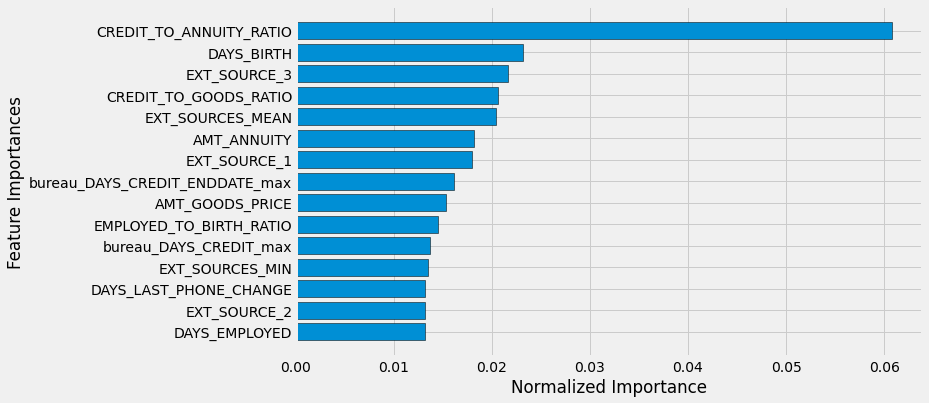

,index,feature,importance,importance_nomalized
0,305,CREDIT_TO_ANNUITY_RATIO,522.0,0.060839
1,6,DAYS_BIRTH,199.2,0.023217
2,28,EXT_SOURCE_3,185.6,0.021632
3,306,CREDIT_TO_GOODS_RATIO,177.2,0.020653
4,302,EXT_SOURCES_MEAN,175.0,0.020396
...,...,...,...,...
457,97,AMT_REQ_CREDIT_BUREAU_HOUR,0.0,0.000000
458,96,FLAG_DOCUMENT_21,0.0,0.000000
459,95,FLAG_DOCUMENT_20,0.0,0.000000
460,94,FLAG_DOCUMENT_19,0.0,0.000000


In [36]:
plot_feature_importances(fi_engineered_removed)

In [37]:
metrics_engineered_removed

,fold,train,valid
0,0,0.817952,0.770907
1,1,0.843912,0.775967
2,2,0.830487,0.770962
3,3,0.825496,0.775095
4,4,0.846139,0.769161
5,overall,0.832797,0.772327


In [38]:
submission_engineered_removed_.to_csv('submission_engineered_removed_.csv', index = False)